In [1]:
import warnings

warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier, Pool, metrics, EFeaturesSelectionAlgorithm
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import umap.umap_ as umap
import shap

from pandarallel import pandarallel
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # to manipulate x-tickers
import plotly.express as px
import seaborn as sns

from collections import Counter
from tqdm import tqdm
import warnings
import random
import pickle
import json
import os

from IPython.core.interactiveshell import InteractiveShell

from samolet_parking_lot.modules.cv import *
from samolet_parking_lot.modules.feature_engineering import *
from samolet_parking_lot.modules.features_selection import *
from samolet_parking_lot.modules.hyperparam_tuning import *
from samolet_parking_lot.modules.model import *
from samolet_parking_lot.modules.utils import *

sns.set(rc={'figure.figsize': (20, 10), 'figure.facecolor': 'white'})
sns.set_palette("viridis")
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
os.environ["TOKENIZERS_PARALLELISM"] = "true"  # activate parallelism
pandarallel.initialize(progress_bar=True)
InteractiveShell.ast_node_interactivity = "all"  # show all outputs, not only the last
seed_everything()

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Stage 1. Data Preparation

In [2]:
data = pd.read_csv("../data/raw/train_dataset_Самолет.csv")

In [3]:
data = create_date_features(data)

In [4]:
# drop columns with big share of missing values
data = remove_null_columns(data, threshold=.999)

In [5]:
# split on train, valid, test with client_id being only withing one split
X_train, X_valid, X_test, y_train, y_valid, y_test = get_train_valid_test_split(data)

# Stage 2. Data Analysis

### Data Inspection

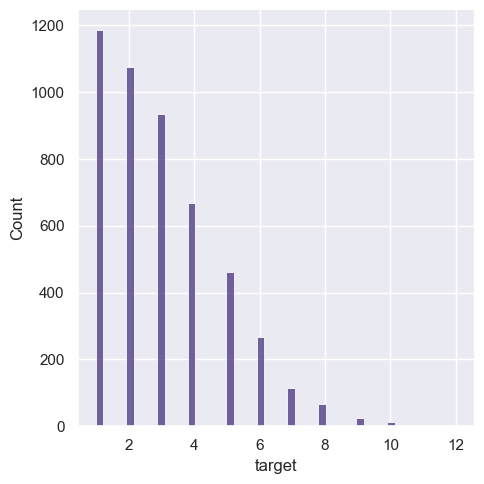

In [6]:
# Qnt of entries per client_id
plt_data = data[['client_id', 'target']].groupby('client_id', as_index=True)['target'].count()
ax = sns.displot(plt_data)
plt.show()

In [7]:
plt_data = (
    data[['client_id', 'target']]
    .groupby('client_id', as_index=True)
    .agg(qnt=('target', 'count'),
         sum=('target', 'sum'))
)
plt_data['success_share'] = plt_data['sum'] / plt_data['qnt']

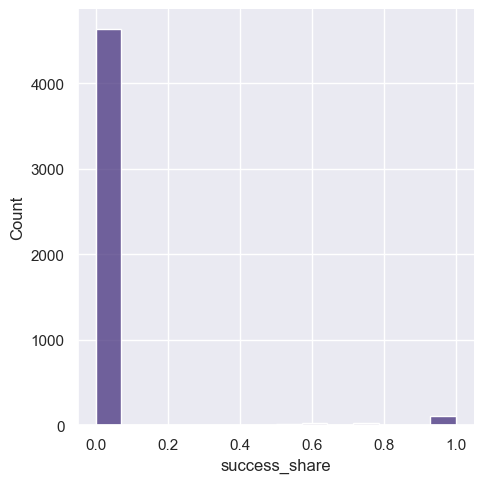

In [8]:
# distribution of share of successful events per client
ax = sns.displot(plt_data.success_share)
plt.show()

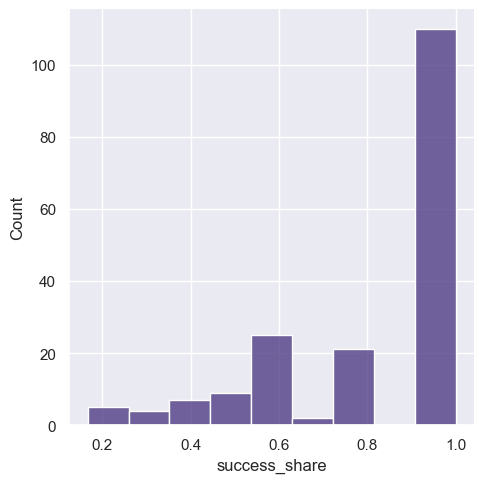

In [9]:
# distribution of share of successful events per client (w/o 0%) (among those who purchases parking lot)
ax = sns.displot(plt_data.query("success_share > 0").success_share)
plt.show()

In [10]:
# share of clents with 1
(
    data[['client_id', 'target']]
    .groupby('target', as_index=True)
    .agg(qnt=('client_id', 'count'))
)

,qnt
target,
0,14020
1,436


### Plot Possible Clusters

In [11]:
data_umap = data[data.select_dtypes(include=['float64', 'int64']).columns].fillna(0)
data_umap = StandardScaler().fit_transform(data_umap)

In [12]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(data_umap)
embedding.shape

(14456, 2)

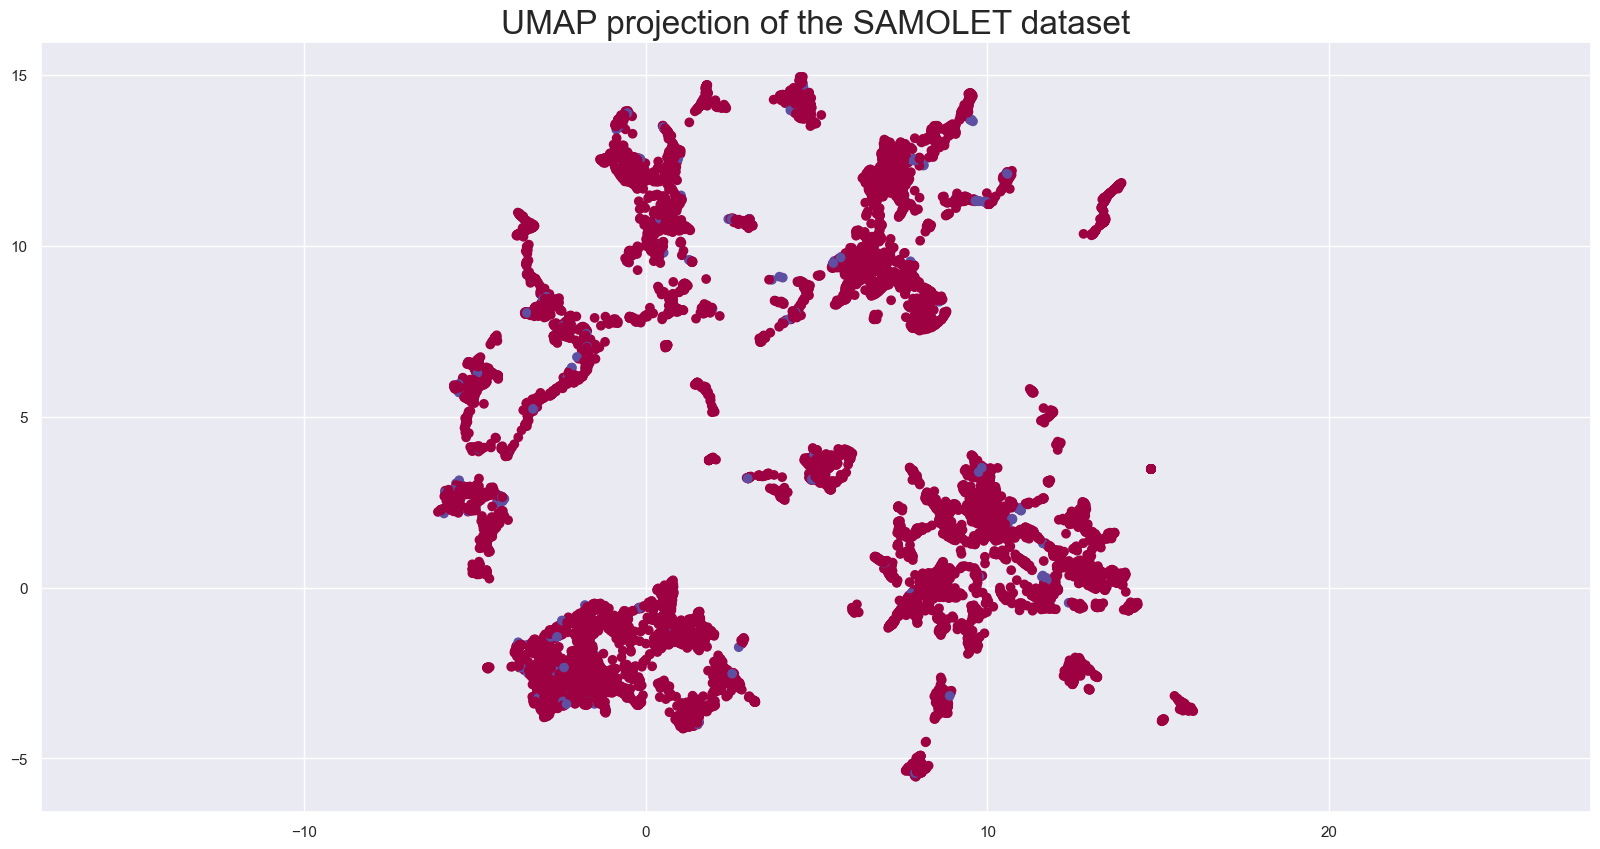

In [13]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=data.target,
    cmap='Spectral',
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the SAMOLET dataset', fontsize=24);

### Dimensionality Reduction

In [14]:
data_umap = X_train[X_train.select_dtypes(include=['float64', 'int64']).columns].fillna(0)
data_umap = StandardScaler().fit_transform(data_umap)

In [15]:
reducer = umap.UMAP(n_components=50)
umap_embedding = reducer.fit_transform(data_umap)

In [16]:
pca = PCA(n_components=400, svd_solver='full')
pca_embedding = pca.fit_transform(data_umap)

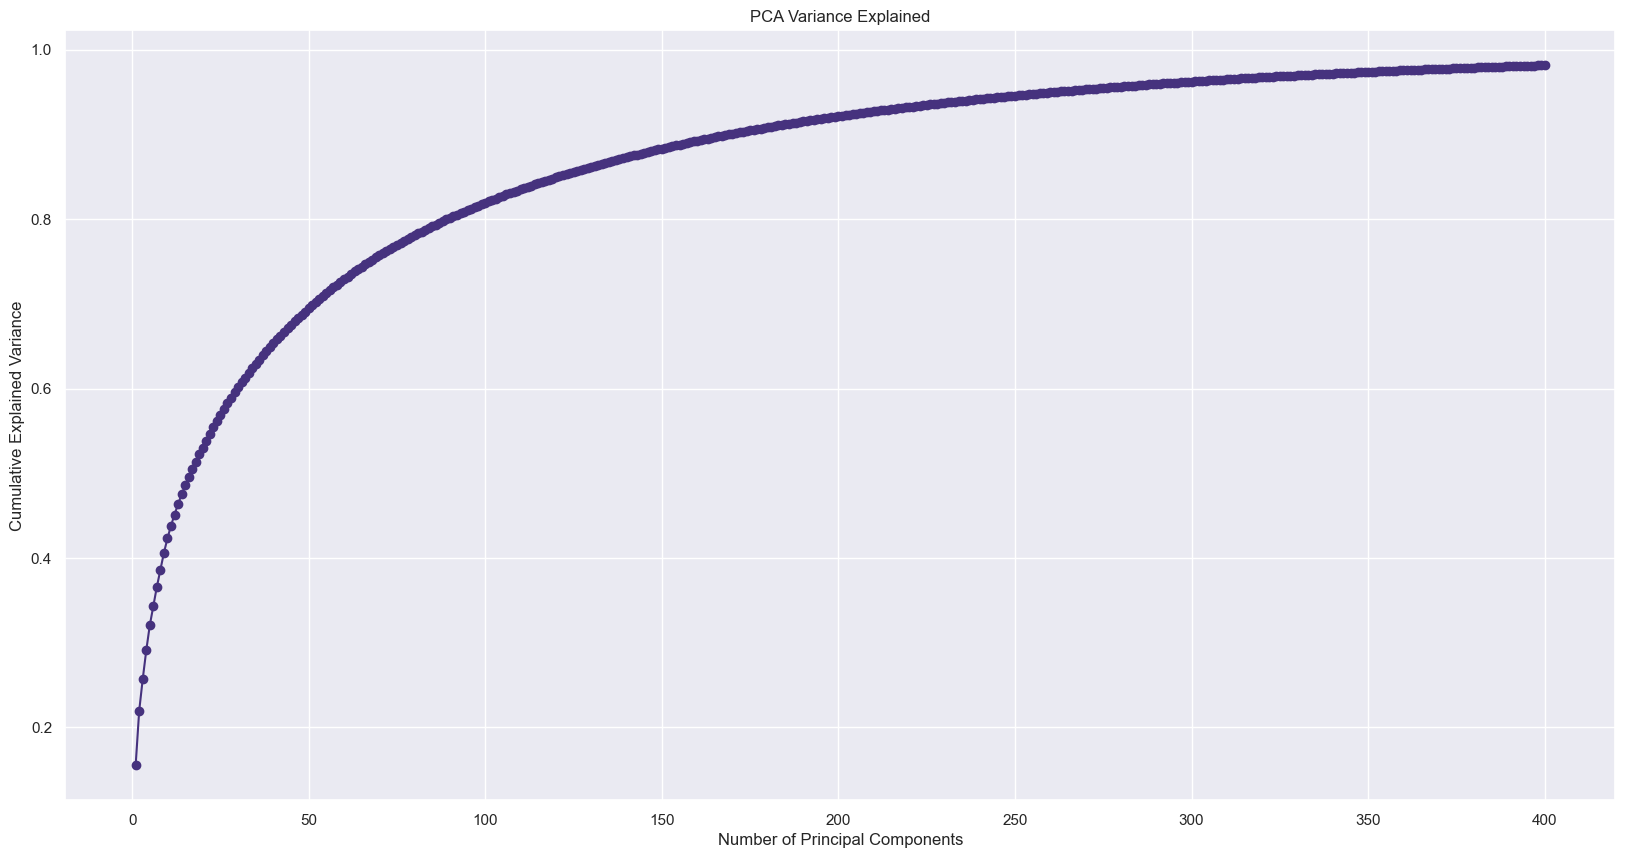

Plot was saved to PCA_varian_without_UMAP


<Figure size 2000x1000 with 0 Axes>

In [17]:
plot_pca_variance(pca, save_to="PCA_varian_without_UMAP")

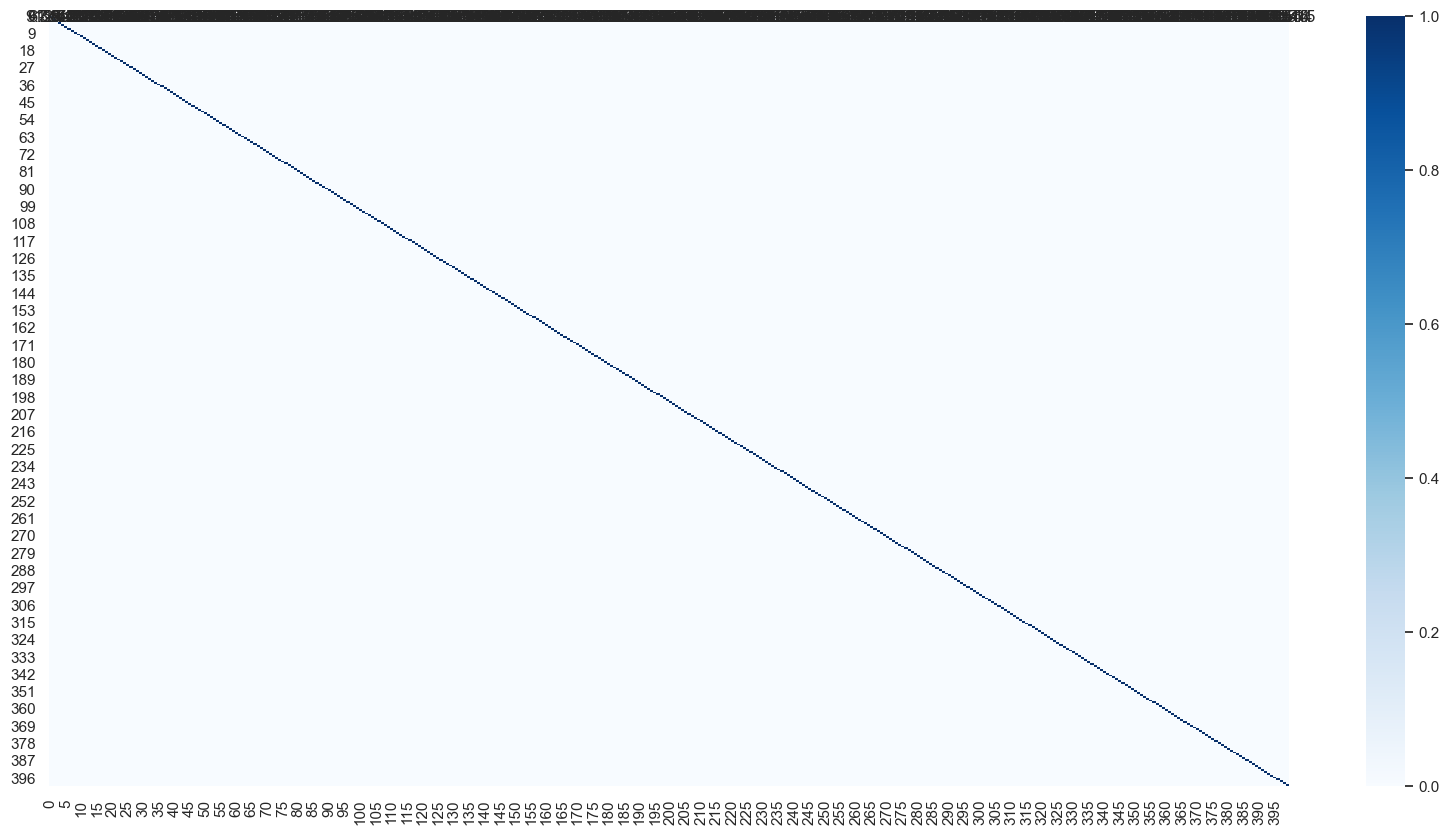

In [18]:
ax = sns.heatmap(pd.DataFrame(pca_embedding).corr(), annot=True, cmap='Blues')
plt.show()

# Stage 3. Model (w/o Feature Selection)

In [19]:
model = catboost_model_classifier(X_train, X_valid, y_train, y_valid)
y_pred = model.predict(X_test)
roc_auc_score(y_test, y_pred)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.8719916502946956

ROC-AUC score is:  0.8719916502946956


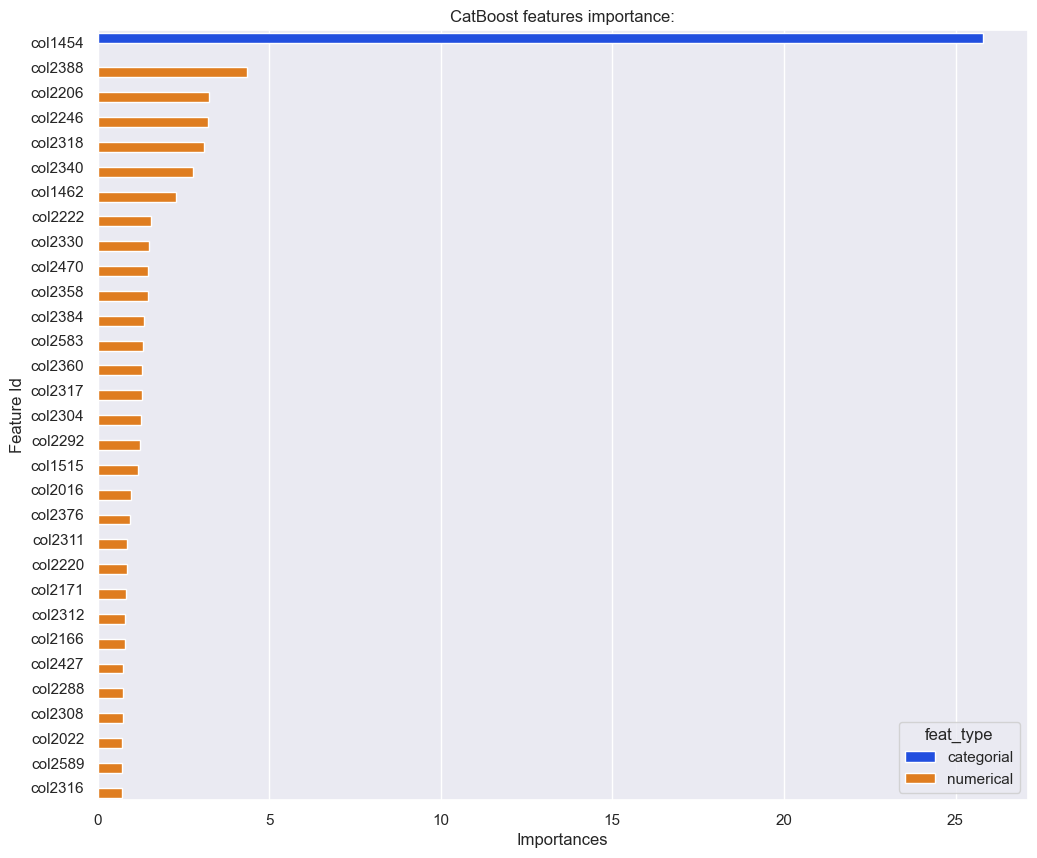

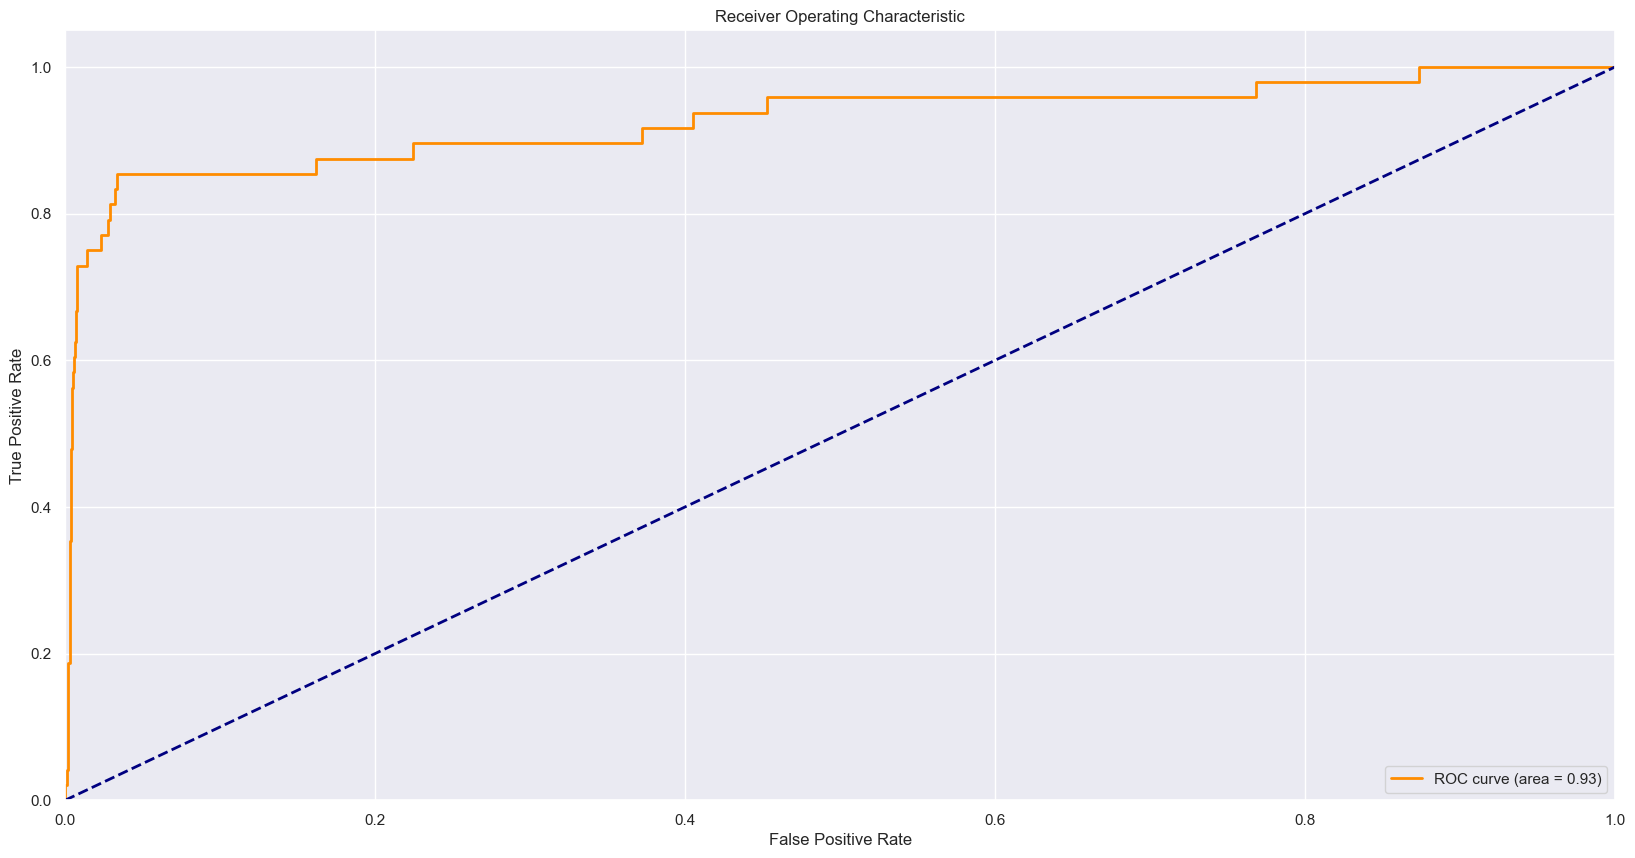

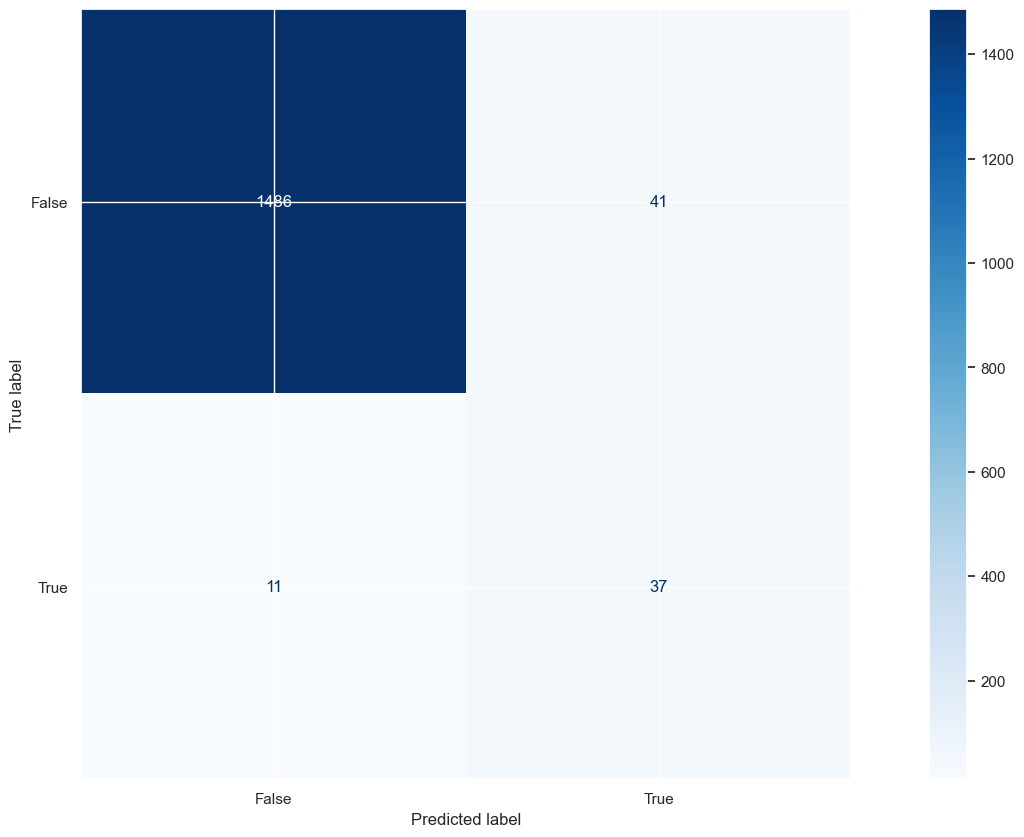

In [20]:
plot_model_info(model, X_test, y_test)  #categorical_columns

# Step 4. Feature Selection

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
2023-09-09 19:44:38,805 INFO From 2407 feature 64 were selected (0.03%).Share of 'Object' type features is: 0.00%


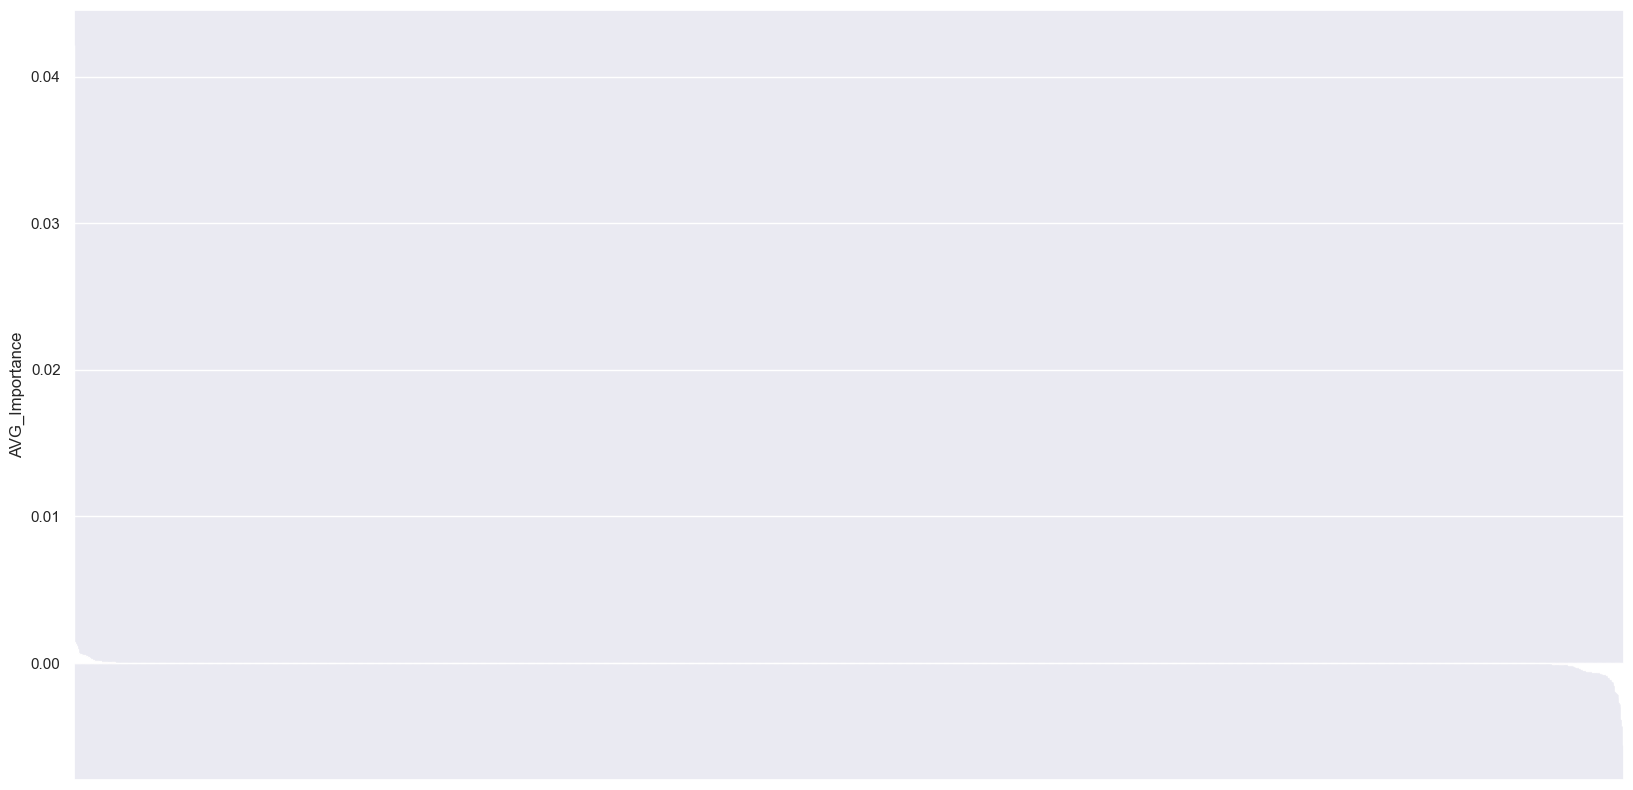

In [21]:
useful_column_indices_sk = get_sklearn_important_features(model, X_train, X_test, y_test, plot=False)
useful_column_indices_rf = get_random_feat_important_features(X_train, y_train, X_valid, y_valid)
useful_column_indices_union = list(set(useful_column_indices_sk + useful_column_indices_rf))

In [22]:
# compare both feature extraction methods
lists_analysis(useful_column_indices_sk, useful_column_indices_rf)

{'intersection': {'absolute': 27, 'percent': 7.12},
 'difference_list1': {'absolute': 37, 'percent': 9.76},
 'difference_list2': {'absolute': 315, 'percent': 83.11}}

In [98]:
useful_column_indices = useful_column_indices_union
X_train_cleaned = X_train.iloc[:, useful_column_indices]
X_valid_cleaned = X_valid.iloc[:, useful_column_indices]
X_test_cleaned = X_test.iloc[:, useful_column_indices]

In [99]:
model_cleansed = catboost_model_classifier(
    X_train_cleaned,
    X_valid_cleaned,
    y_train, y_valid
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

ROC-AUC score is:  0.8745497707924033


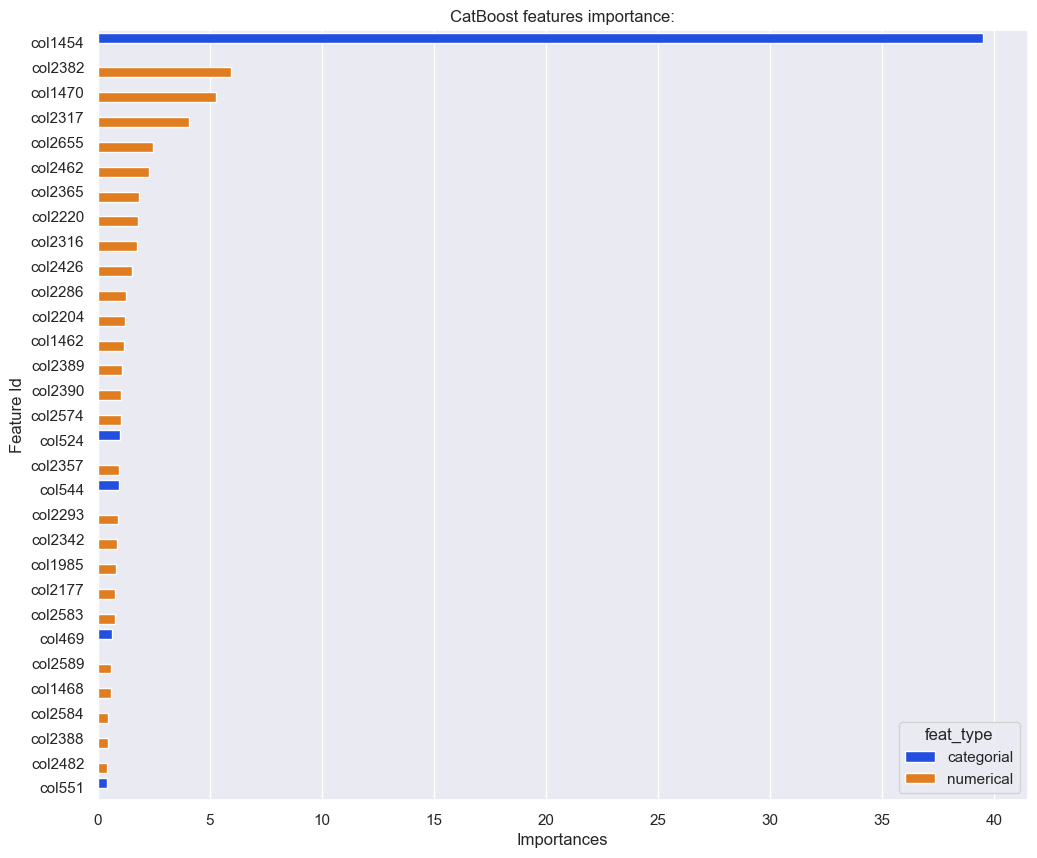

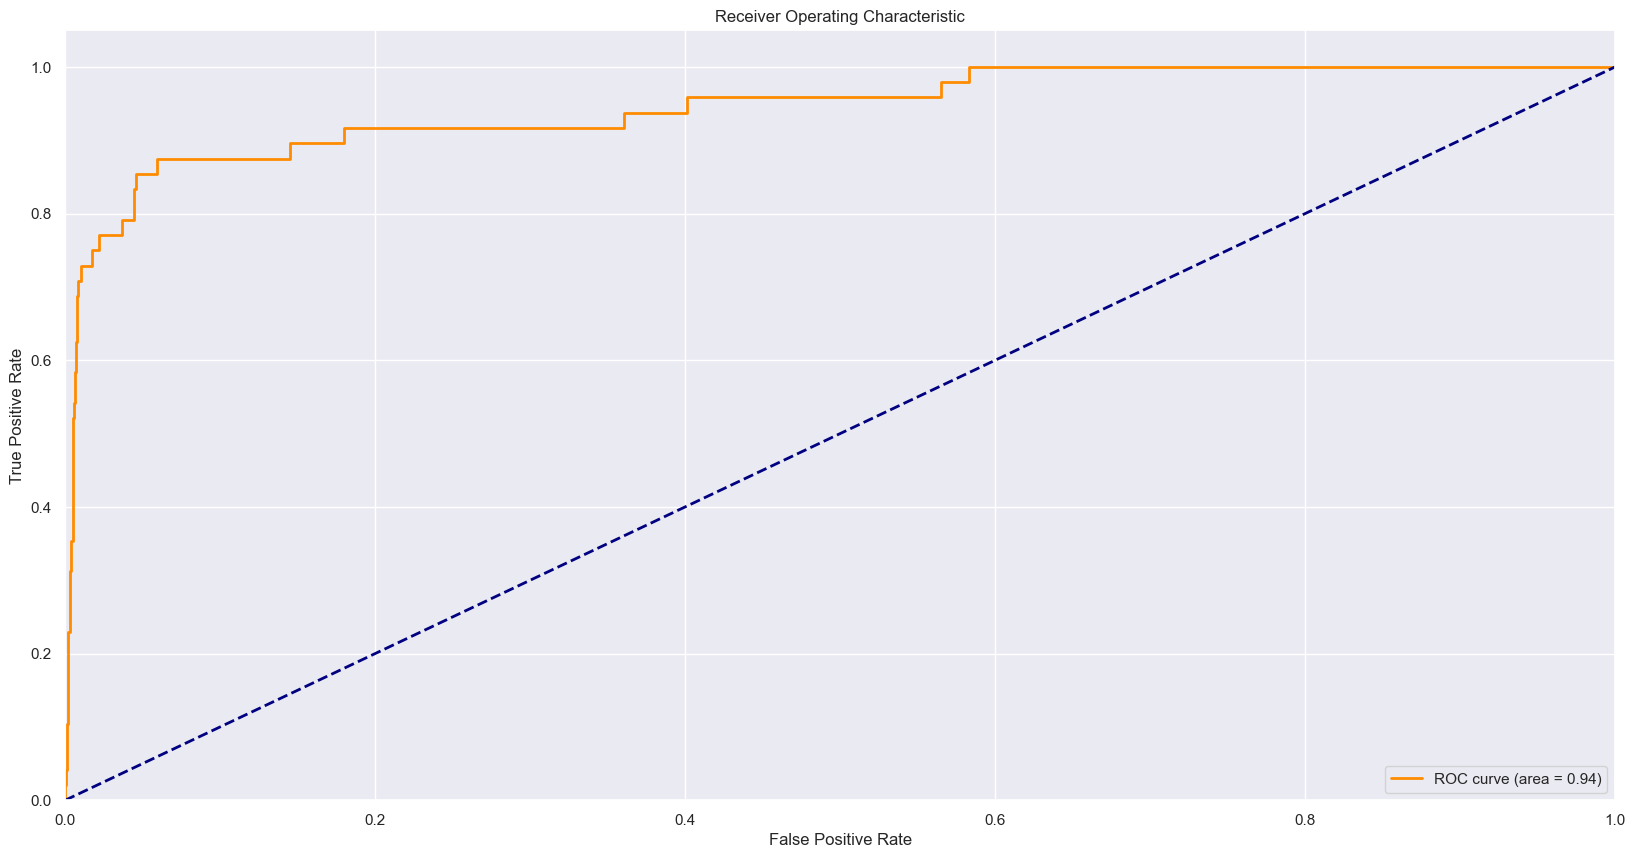

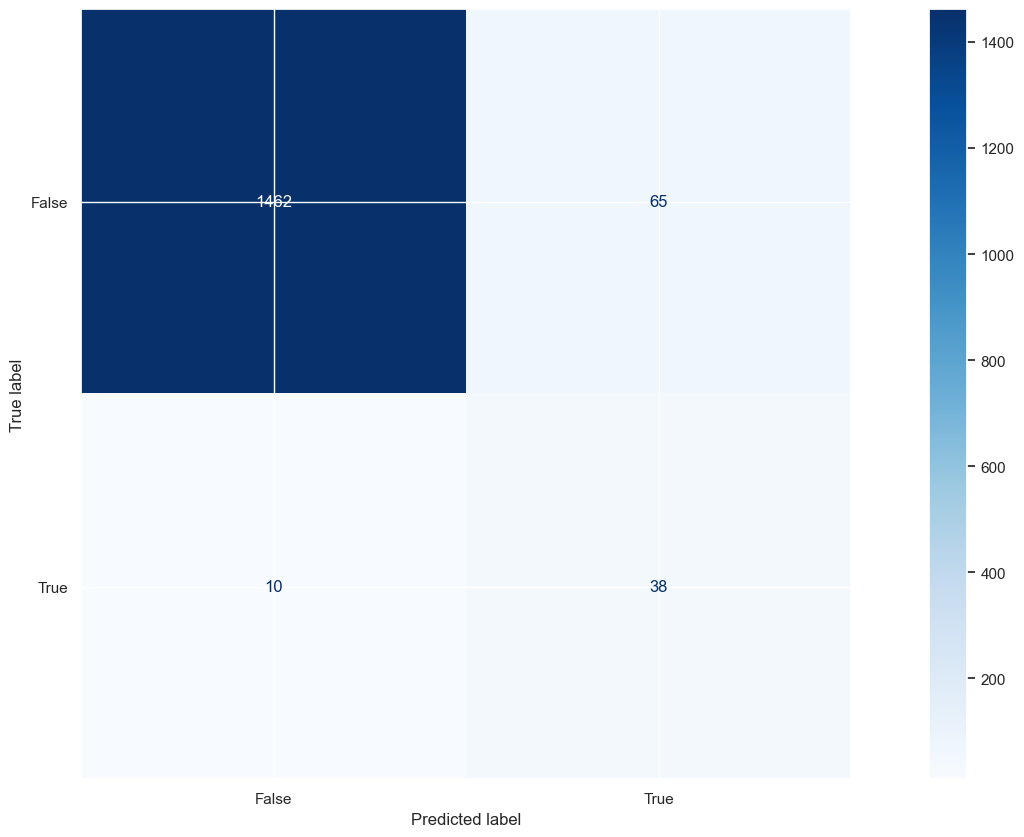

In [100]:
plot_model_info(
    model_cleansed,
    X_test_cleaned,
    y_test,
    # X_test_cleaned.select_dtypes(exclude=["float64", "int64"]).columns.to_list()
)

# Step 5. Hyperparameters Tuning

In [101]:
search_new_params = True
if search_new_params:
    hyperparams = search_best_params(X_train_cleaned, X_valid_cleaned, y_train, y_valid, max_evals=300)
else:
    with open('best_hyperparams_full_dataset.pkl', 'rb') as fp:
        hyperparams = pickle.load(fp)

  0%|          | 0/300 [00:00<?, ?trial/s, best loss=?]

2023-09-09 20:58:38,157 INFO build_posterior_wrapper took 0.000316 seconds
2023-09-09 20:58:38,157 INFO TPE using 0 trials


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  0%|          | 1/300 [00:08<40:53,  8.20s/trial, best loss: 0.2828032027514025]

2023-09-09 20:58:46,362 INFO build_posterior_wrapper took 0.000353 seconds
2023-09-09 20:58:46,362 INFO TPE using 1/1 trials with best loss 0.282803


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  1%|          | 2/300 [00:11<26:27,  5.33s/trial, best loss: 0.2828032027514025]

2023-09-09 20:58:49,674 INFO build_posterior_wrapper took 0.000306 seconds
2023-09-09 20:58:49,674 INFO TPE using 2/2 trials with best loss 0.282803


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  1%|          | 3/300 [00:15<22:24,  4.53s/trial, best loss: 0.2828032027514025]

2023-09-09 20:58:53,249 INFO build_posterior_wrapper took 0.000391 seconds
2023-09-09 20:58:53,249 INFO TPE using 3/3 trials with best loss 0.282803


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  1%|▏         | 4/300 [00:16<15:50,  3.21s/trial, best loss: 0.2828032027514025]

2023-09-09 20:58:54,440 INFO build_posterior_wrapper took 0.000407 seconds
2023-09-09 20:58:54,441 INFO TPE using 4/4 trials with best loss 0.282803


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  2%|▏         | 5/300 [00:17<11:51,  2.41s/trial, best loss: 0.2730375869406976]

2023-09-09 20:58:55,433 INFO build_posterior_wrapper took 0.000341 seconds
2023-09-09 20:58:55,433 INFO TPE using 5/5 trials with best loss 0.273038


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  2%|▏         | 6/300 [00:20<13:33,  2.77s/trial, best loss: 0.27169214196092545]

2023-09-09 20:58:58,894 INFO build_posterior_wrapper took 0.000354 seconds
2023-09-09 20:58:58,894 INFO TPE using 6/6 trials with best loss 0.271692


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  2%|▏         | 7/300 [00:23<12:53,  2.64s/trial, best loss: 0.27169214196092545]

2023-09-09 20:59:01,274 INFO build_posterior_wrapper took 0.000309 seconds
2023-09-09 20:59:01,275 INFO TPE using 7/7 trials with best loss 0.271692


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  3%|▎         | 8/300 [00:26<14:26,  2.97s/trial, best loss: 0.27169214196092545]

2023-09-09 20:59:04,940 INFO build_posterior_wrapper took 0.000388 seconds
2023-09-09 20:59:04,944 INFO TPE using 8/8 trials with best loss 0.271692


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  3%|▎         | 9/300 [00:29<13:49,  2.85s/trial, best loss: 0.27169214196092545]

2023-09-09 20:59:07,534 INFO build_posterior_wrapper took 0.000344 seconds
2023-09-09 20:59:07,535 INFO TPE using 9/9 trials with best loss 0.271692


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  3%|▎         | 10/300 [00:34<16:49,  3.48s/trial, best loss: 0.27169214196092545]

2023-09-09 20:59:12,423 INFO build_posterior_wrapper took 0.000341 seconds
2023-09-09 20:59:12,424 INFO TPE using 10/10 trials with best loss 0.271692


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  4%|▎         | 11/300 [00:37<16:53,  3.51s/trial, best loss: 0.27169214196092545]

2023-09-09 20:59:15,988 INFO build_posterior_wrapper took 0.000345 seconds
2023-09-09 20:59:15,989 INFO TPE using 11/11 trials with best loss 0.271692


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  4%|▍         | 12/300 [00:40<15:02,  3.13s/trial, best loss: 0.27169214196092545]

2023-09-09 20:59:18,270 INFO build_posterior_wrapper took 0.000542 seconds
2023-09-09 20:59:18,271 INFO TPE using 12/12 trials with best loss 0.271692


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  4%|▍         | 13/300 [00:43<15:47,  3.30s/trial, best loss: 0.27169214196092545]

2023-09-09 20:59:21,962 INFO build_posterior_wrapper took 0.000328 seconds
2023-09-09 20:59:21,964 INFO TPE using 13/13 trials with best loss 0.271692


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  5%|▍         | 14/300 [00:46<14:26,  3.03s/trial, best loss: 0.27169214196092545]

2023-09-09 20:59:24,366 INFO build_posterior_wrapper took 0.000365 seconds
2023-09-09 20:59:24,367 INFO TPE using 14/14 trials with best loss 0.271692


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  5%|▌         | 15/300 [00:48<13:29,  2.84s/trial, best loss: 0.2708204302552589] 

2023-09-09 20:59:26,762 INFO build_posterior_wrapper took 0.000303 seconds
2023-09-09 20:59:26,762 INFO TPE using 15/15 trials with best loss 0.270820


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  5%|▌         | 16/300 [00:50<12:18,  2.60s/trial, best loss: 0.2708204302552589]

2023-09-09 20:59:28,807 INFO build_posterior_wrapper took 0.000318 seconds
2023-09-09 20:59:28,807 INFO TPE using 16/16 trials with best loss 0.270820


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  6%|▌         | 17/300 [00:52<10:37,  2.25s/trial, best loss: 0.2708204302552589]

2023-09-09 20:59:30,252 INFO build_posterior_wrapper took 0.000315 seconds
2023-09-09 20:59:30,252 INFO TPE using 17/17 trials with best loss 0.270820


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  6%|▌         | 18/300 [00:55<12:10,  2.59s/trial, best loss: 0.2708204302552589]

2023-09-09 20:59:33,628 INFO build_posterior_wrapper took 0.000372 seconds
2023-09-09 20:59:33,629 INFO TPE using 18/18 trials with best loss 0.270820


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  6%|▋         | 19/300 [00:57<11:45,  2.51s/trial, best loss: 0.2708204302552589]

2023-09-09 20:59:35,949 INFO build_posterior_wrapper took 0.000319 seconds
2023-09-09 20:59:35,949 INFO TPE using 19/19 trials with best loss 0.270820


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  7%|▋         | 20/300 [00:58<09:44,  2.09s/trial, best loss: 0.2708204302552589]

2023-09-09 20:59:37,049 INFO build_posterior_wrapper took 0.000317 seconds
2023-09-09 20:59:37,049 INFO TPE using 20/20 trials with best loss 0.270820


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  7%|▋         | 21/300 [01:01<10:14,  2.20s/trial, best loss: 0.2708204302552589]

2023-09-09 20:59:39,526 INFO build_posterior_wrapper took 0.000344 seconds
2023-09-09 20:59:39,527 INFO TPE using 21/21 trials with best loss 0.270820


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  7%|▋         | 22/300 [01:04<11:17,  2.44s/trial, best loss: 0.2708204302552589]

2023-09-09 20:59:42,504 INFO build_posterior_wrapper took 0.000372 seconds
2023-09-09 20:59:42,504 INFO TPE using 22/22 trials with best loss 0.270820


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  8%|▊         | 23/300 [01:07<12:42,  2.75s/trial, best loss: 0.2708204302552589]

2023-09-09 20:59:45,993 INFO build_posterior_wrapper took 0.000470 seconds
2023-09-09 20:59:45,993 INFO TPE using 23/23 trials with best loss 0.270820


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  8%|▊         | 24/300 [01:11<13:21,  2.90s/trial, best loss: 0.2708204302552589]

2023-09-09 20:59:49,246 INFO build_posterior_wrapper took 0.000384 seconds
2023-09-09 20:59:49,246 INFO TPE using 24/24 trials with best loss 0.270820


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  8%|▊         | 25/300 [01:13<13:07,  2.86s/trial, best loss: 0.2708204302552589]

2023-09-09 20:59:52,015 INFO build_posterior_wrapper took 0.000365 seconds
2023-09-09 20:59:52,015 INFO TPE using 25/25 trials with best loss 0.270820


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  9%|▊         | 26/300 [01:15<11:02,  2.42s/trial, best loss: 0.2708204302552589]

2023-09-09 20:59:53,397 INFO build_posterior_wrapper took 0.000331 seconds
2023-09-09 20:59:53,397 INFO TPE using 26/26 trials with best loss 0.270820


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  9%|▉         | 27/300 [01:20<14:17,  3.14s/trial, best loss: 0.2708204302552589]

2023-09-09 20:59:58,224 INFO build_posterior_wrapper took 0.000354 seconds
2023-09-09 20:59:58,225 INFO TPE using 27/27 trials with best loss 0.270820


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

  9%|▉         | 28/300 [01:27<19:57,  4.40s/trial, best loss: 0.2708204302552589]

2023-09-09 21:00:05,574 INFO build_posterior_wrapper took 0.000316 seconds
2023-09-09 21:00:05,575 INFO TPE using 28/28 trials with best loss 0.270820


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 10%|▉         | 29/300 [01:35<24:52,  5.51s/trial, best loss: 0.2708204302552589]

2023-09-09 21:00:13,655 INFO build_posterior_wrapper took 0.000342 seconds
2023-09-09 21:00:13,660 INFO TPE using 29/29 trials with best loss 0.270820


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 10%|█         | 30/300 [01:42<26:19,  5.85s/trial, best loss: 0.2682420963737489]

2023-09-09 21:00:20,305 INFO build_posterior_wrapper took 0.000309 seconds
2023-09-09 21:00:20,305 INFO TPE using 30/30 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 10%|█         | 31/300 [01:44<21:33,  4.81s/trial, best loss: 0.2682420963737489]

2023-09-09 21:00:22,681 INFO build_posterior_wrapper took 0.000321 seconds
2023-09-09 21:00:22,681 INFO TPE using 31/31 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 11%|█         | 32/300 [01:48<20:38,  4.62s/trial, best loss: 0.2682420963737489]

2023-09-09 21:00:26,871 INFO build_posterior_wrapper took 0.000315 seconds
2023-09-09 21:00:26,871 INFO TPE using 32/32 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 11%|█         | 33/300 [01:51<18:00,  4.05s/trial, best loss: 0.2682420963737489]

2023-09-09 21:00:29,569 INFO build_posterior_wrapper took 0.000315 seconds
2023-09-09 21:00:29,570 INFO TPE using 33/33 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 11%|█▏        | 34/300 [01:54<16:55,  3.82s/trial, best loss: 0.2682420963737489]

2023-09-09 21:00:32,856 INFO build_posterior_wrapper took 0.000326 seconds
2023-09-09 21:00:32,856 INFO TPE using 34/34 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 12%|█▏        | 35/300 [01:57<15:45,  3.57s/trial, best loss: 0.2682420963737489]

2023-09-09 21:00:35,836 INFO build_posterior_wrapper took 0.000348 seconds
2023-09-09 21:00:35,836 INFO TPE using 35/35 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 12%|█▏        | 36/300 [01:58<12:23,  2.82s/trial, best loss: 0.2682420963737489]

2023-09-09 21:00:36,899 INFO build_posterior_wrapper took 0.000299 seconds
2023-09-09 21:00:36,899 INFO TPE using 36/36 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 12%|█▏        | 37/300 [02:00<11:25,  2.61s/trial, best loss: 0.2682420963737489]

2023-09-09 21:00:39,016 INFO build_posterior_wrapper took 0.000354 seconds
2023-09-09 21:00:39,016 INFO TPE using 37/37 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 13%|█▎        | 38/300 [02:04<12:41,  2.91s/trial, best loss: 0.2682420963737489]

2023-09-09 21:00:42,624 INFO build_posterior_wrapper took 0.000341 seconds
2023-09-09 21:00:42,625 INFO TPE using 38/38 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 13%|█▎        | 39/300 [02:07<13:12,  3.04s/trial, best loss: 0.2682420963737489]

2023-09-09 21:00:45,964 INFO build_posterior_wrapper took 0.000386 seconds
2023-09-09 21:00:45,964 INFO TPE using 39/39 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 13%|█▎        | 40/300 [02:11<14:32,  3.35s/trial, best loss: 0.2682420963737489]

2023-09-09 21:00:50,060 INFO build_posterior_wrapper took 0.000297 seconds
2023-09-09 21:00:50,061 INFO TPE using 40/40 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 14%|█▎        | 41/300 [02:15<14:51,  3.44s/trial, best loss: 0.2682420963737489]

2023-09-09 21:00:53,710 INFO build_posterior_wrapper took 0.000365 seconds
2023-09-09 21:00:53,711 INFO TPE using 41/41 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 14%|█▍        | 42/300 [02:21<17:48,  4.14s/trial, best loss: 0.2682420963737489]

2023-09-09 21:00:59,478 INFO build_posterior_wrapper took 0.000510 seconds
2023-09-09 21:00:59,478 INFO TPE using 42/42 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 14%|█▍        | 43/300 [02:24<17:04,  3.99s/trial, best loss: 0.2682420963737489]

2023-09-09 21:01:03,106 INFO build_posterior_wrapper took 0.000399 seconds
2023-09-09 21:01:03,106 INFO TPE using 43/43 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 15%|█▍        | 44/300 [02:26<14:27,  3.39s/trial, best loss: 0.2682420963737489]

2023-09-09 21:01:05,096 INFO build_posterior_wrapper took 0.000343 seconds
2023-09-09 21:01:05,097 INFO TPE using 44/44 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 15%|█▌        | 45/300 [02:28<12:21,  2.91s/trial, best loss: 0.2682420963737489]

2023-09-09 21:01:06,884 INFO build_posterior_wrapper took 0.000509 seconds
2023-09-09 21:01:06,884 INFO TPE using 45/45 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 15%|█▌        | 46/300 [02:33<14:10,  3.35s/trial, best loss: 0.2682420963737489]

2023-09-09 21:01:11,263 INFO build_posterior_wrapper took 0.000376 seconds
2023-09-09 21:01:11,263 INFO TPE using 46/46 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 16%|█▌        | 47/300 [02:35<12:49,  3.04s/trial, best loss: 0.2682420963737489]

2023-09-09 21:01:13,590 INFO build_posterior_wrapper took 0.000302 seconds
2023-09-09 21:01:13,590 INFO TPE using 47/47 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 16%|█▌        | 48/300 [02:36<10:18,  2.45s/trial, best loss: 0.2682420963737489]

2023-09-09 21:01:14,668 INFO build_posterior_wrapper took 0.000314 seconds
2023-09-09 21:01:14,668 INFO TPE using 48/48 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 16%|█▋        | 49/300 [02:40<11:39,  2.79s/trial, best loss: 0.2682420963737489]

2023-09-09 21:01:18,238 INFO build_posterior_wrapper took 0.000318 seconds
2023-09-09 21:01:18,239 INFO TPE using 49/49 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 17%|█▋        | 50/300 [02:42<11:09,  2.68s/trial, best loss: 0.2682420963737489]

2023-09-09 21:01:20,665 INFO build_posterior_wrapper took 0.000310 seconds
2023-09-09 21:01:20,665 INFO TPE using 50/50 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 17%|█▋        | 51/300 [02:44<10:19,  2.49s/trial, best loss: 0.2682420963737489]

2023-09-09 21:01:22,712 INFO build_posterior_wrapper took 0.000314 seconds
2023-09-09 21:01:22,712 INFO TPE using 51/51 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 17%|█▋        | 52/300 [02:46<10:05,  2.44s/trial, best loss: 0.2682420963737489]

2023-09-09 21:01:25,040 INFO build_posterior_wrapper took 0.000340 seconds
2023-09-09 21:01:25,040 INFO TPE using 52/52 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 18%|█▊        | 53/300 [02:50<11:18,  2.75s/trial, best loss: 0.2682420963737489]

2023-09-09 21:01:28,505 INFO build_posterior_wrapper took 0.000325 seconds
2023-09-09 21:01:28,506 INFO TPE using 53/53 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 18%|█▊        | 54/300 [02:53<11:41,  2.85s/trial, best loss: 0.2682420963737489]

2023-09-09 21:01:31,600 INFO build_posterior_wrapper took 0.000359 seconds
2023-09-09 21:01:31,600 INFO TPE using 54/54 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 18%|█▊        | 55/300 [02:56<12:10,  2.98s/trial, best loss: 0.2682420963737489]

2023-09-09 21:01:34,886 INFO build_posterior_wrapper took 0.000305 seconds
2023-09-09 21:01:34,887 INFO TPE using 55/55 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 19%|█▊        | 56/300 [02:59<11:26,  2.82s/trial, best loss: 0.2682420963737489]

2023-09-09 21:01:37,311 INFO build_posterior_wrapper took 0.000378 seconds
2023-09-09 21:01:37,312 INFO TPE using 56/56 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 19%|█▉        | 57/300 [03:01<10:39,  2.63s/trial, best loss: 0.2682420963737489]

2023-09-09 21:01:39,519 INFO build_posterior_wrapper took 0.000357 seconds
2023-09-09 21:01:39,520 INFO TPE using 57/57 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 19%|█▉        | 58/300 [03:04<10:58,  2.72s/trial, best loss: 0.2682420963737489]

2023-09-09 21:01:42,442 INFO build_posterior_wrapper took 0.000366 seconds
2023-09-09 21:01:42,442 INFO TPE using 58/58 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 20%|█▉        | 59/300 [03:06<10:25,  2.59s/trial, best loss: 0.2682420963737489]

2023-09-09 21:01:44,743 INFO build_posterior_wrapper took 0.000386 seconds
2023-09-09 21:01:44,743 INFO TPE using 59/59 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 20%|██        | 60/300 [03:11<13:17,  3.32s/trial, best loss: 0.2682420963737489]

2023-09-09 21:01:49,767 INFO build_posterior_wrapper took 0.000298 seconds
2023-09-09 21:01:49,767 INFO TPE using 60/60 trials with best loss 0.268242


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 20%|██        | 61/300 [03:14<12:12,  3.07s/trial, best loss: 0.2618701293948336]

2023-09-09 21:01:52,236 INFO build_posterior_wrapper took 0.000355 seconds
2023-09-09 21:01:52,236 INFO TPE using 61/61 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 21%|██        | 62/300 [03:17<12:36,  3.18s/trial, best loss: 0.2618701293948336]

2023-09-09 21:01:55,674 INFO build_posterior_wrapper took 0.000346 seconds
2023-09-09 21:01:55,674 INFO TPE using 62/62 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 21%|██        | 63/300 [03:19<11:34,  2.93s/trial, best loss: 0.2618701293948336]

2023-09-09 21:01:58,021 INFO build_posterior_wrapper took 0.000359 seconds
2023-09-09 21:01:58,022 INFO TPE using 63/63 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 21%|██▏       | 64/300 [03:21<09:50,  2.50s/trial, best loss: 0.2618701293948336]

2023-09-09 21:01:59,526 INFO build_posterior_wrapper took 0.000312 seconds
2023-09-09 21:01:59,526 INFO TPE using 64/64 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 22%|██▏       | 65/300 [03:24<10:04,  2.57s/trial, best loss: 0.2618701293948336]

2023-09-09 21:02:02,269 INFO build_posterior_wrapper took 0.000341 seconds
2023-09-09 21:02:02,269 INFO TPE using 65/65 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 22%|██▏       | 66/300 [03:25<08:49,  2.26s/trial, best loss: 0.2618701293948336]

2023-09-09 21:02:03,805 INFO build_posterior_wrapper took 0.000330 seconds
2023-09-09 21:02:03,806 INFO TPE using 66/66 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 22%|██▏       | 67/300 [03:28<09:20,  2.41s/trial, best loss: 0.2618701293948336]

2023-09-09 21:02:06,548 INFO build_posterior_wrapper took 0.000330 seconds
2023-09-09 21:02:06,549 INFO TPE using 67/67 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 23%|██▎       | 68/300 [03:33<12:46,  3.31s/trial, best loss: 0.2618701293948336]

2023-09-09 21:02:11,949 INFO build_posterior_wrapper took 0.000349 seconds
2023-09-09 21:02:11,950 INFO TPE using 68/68 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 23%|██▎       | 69/300 [03:37<12:49,  3.33s/trial, best loss: 0.2618701293948336]

2023-09-09 21:02:15,343 INFO build_posterior_wrapper took 0.000341 seconds
2023-09-09 21:02:15,343 INFO TPE using 69/69 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 23%|██▎       | 70/300 [03:39<11:02,  2.88s/trial, best loss: 0.2618701293948336]

2023-09-09 21:02:17,163 INFO build_posterior_wrapper took 0.000330 seconds
2023-09-09 21:02:17,164 INFO TPE using 70/70 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 24%|██▎       | 71/300 [03:40<09:38,  2.53s/trial, best loss: 0.2618701293948336]

2023-09-09 21:02:18,864 INFO build_posterior_wrapper took 0.000320 seconds
2023-09-09 21:02:18,865 INFO TPE using 71/71 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 24%|██▍       | 72/300 [03:42<09:15,  2.44s/trial, best loss: 0.2618701293948336]

2023-09-09 21:02:21,094 INFO build_posterior_wrapper took 0.000341 seconds
2023-09-09 21:02:21,094 INFO TPE using 72/72 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 24%|██▍       | 73/300 [03:45<09:44,  2.57s/trial, best loss: 0.2618701293948336]

2023-09-09 21:02:23,987 INFO build_posterior_wrapper took 0.000357 seconds
2023-09-09 21:02:23,987 INFO TPE using 73/73 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 25%|██▍       | 74/300 [03:47<08:36,  2.28s/trial, best loss: 0.2618701293948336]

2023-09-09 21:02:25,595 INFO build_posterior_wrapper took 0.000309 seconds
2023-09-09 21:02:25,595 INFO TPE using 74/74 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 25%|██▌       | 75/300 [03:51<10:05,  2.69s/trial, best loss: 0.2618701293948336]

2023-09-09 21:02:29,243 INFO build_posterior_wrapper took 0.000372 seconds
2023-09-09 21:02:29,243 INFO TPE using 75/75 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 25%|██▌       | 76/300 [03:59<16:00,  4.29s/trial, best loss: 0.2618701293948336]

2023-09-09 21:02:37,248 INFO build_posterior_wrapper took 0.000298 seconds
2023-09-09 21:02:37,248 INFO TPE using 76/76 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 26%|██▌       | 77/300 [04:02<14:47,  3.98s/trial, best loss: 0.2618701293948336]

2023-09-09 21:02:40,509 INFO build_posterior_wrapper took 0.000382 seconds
2023-09-09 21:02:40,509 INFO TPE using 77/77 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 26%|██▌       | 78/300 [04:09<18:32,  5.01s/trial, best loss: 0.2618701293948336]

2023-09-09 21:02:47,930 INFO build_posterior_wrapper took 0.000348 seconds
2023-09-09 21:02:47,930 INFO TPE using 78/78 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 26%|██▋       | 79/300 [04:16<20:40,  5.61s/trial, best loss: 0.2618701293948336]

2023-09-09 21:02:54,941 INFO build_posterior_wrapper took 0.000602 seconds
2023-09-09 21:02:54,942 INFO TPE using 79/79 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 27%|██▋       | 80/300 [04:21<19:20,  5.27s/trial, best loss: 0.2618701293948336]

2023-09-09 21:02:59,427 INFO build_posterior_wrapper took 0.000381 seconds
2023-09-09 21:02:59,427 INFO TPE using 80/80 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 27%|██▋       | 81/300 [04:22<14:40,  4.02s/trial, best loss: 0.2618701293948336]

2023-09-09 21:03:00,528 INFO build_posterior_wrapper took 0.000369 seconds
2023-09-09 21:03:00,528 INFO TPE using 81/81 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 27%|██▋       | 82/300 [04:25<13:14,  3.64s/trial, best loss: 0.2618701293948336]

2023-09-09 21:03:03,292 INFO build_posterior_wrapper took 0.000368 seconds
2023-09-09 21:03:03,292 INFO TPE using 82/82 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 28%|██▊       | 83/300 [04:29<13:40,  3.78s/trial, best loss: 0.2618701293948336]

2023-09-09 21:03:07,398 INFO build_posterior_wrapper took 0.000324 seconds
2023-09-09 21:03:07,399 INFO TPE using 83/83 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 28%|██▊       | 84/300 [04:31<11:56,  3.32s/trial, best loss: 0.2618701293948336]

2023-09-09 21:03:09,629 INFO build_posterior_wrapper took 0.000382 seconds
2023-09-09 21:03:09,630 INFO TPE using 84/84 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 28%|██▊       | 85/300 [04:34<11:14,  3.14s/trial, best loss: 0.2618701293948336]

2023-09-09 21:03:12,348 INFO build_posterior_wrapper took 0.000363 seconds
2023-09-09 21:03:12,348 INFO TPE using 85/85 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 29%|██▊       | 86/300 [04:36<10:25,  2.92s/trial, best loss: 0.2618701293948336]

2023-09-09 21:03:14,773 INFO build_posterior_wrapper took 0.000385 seconds
2023-09-09 21:03:14,774 INFO TPE using 86/86 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 29%|██▉       | 87/300 [04:39<10:30,  2.96s/trial, best loss: 0.2618701293948336]

2023-09-09 21:03:17,823 INFO build_posterior_wrapper took 0.000376 seconds
2023-09-09 21:03:17,824 INFO TPE using 87/87 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 29%|██▉       | 88/300 [04:42<09:54,  2.80s/trial, best loss: 0.2618701293948336]

2023-09-09 21:03:20,258 INFO build_posterior_wrapper took 0.000344 seconds
2023-09-09 21:03:20,258 INFO TPE using 88/88 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 30%|██▉       | 89/300 [04:46<11:04,  3.15s/trial, best loss: 0.2618701293948336]

2023-09-09 21:03:24,207 INFO build_posterior_wrapper took 0.000307 seconds
2023-09-09 21:03:24,207 INFO TPE using 89/89 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 30%|███       | 90/300 [04:50<12:04,  3.45s/trial, best loss: 0.2618701293948336]

2023-09-09 21:03:28,356 INFO build_posterior_wrapper took 0.000384 seconds
2023-09-09 21:03:28,356 INFO TPE using 90/90 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 30%|███       | 91/300 [04:57<16:03,  4.61s/trial, best loss: 0.2618701293948336]

2023-09-09 21:03:35,683 INFO build_posterior_wrapper took 0.000344 seconds
2023-09-09 21:03:35,683 INFO TPE using 91/91 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 31%|███       | 92/300 [05:01<15:00,  4.33s/trial, best loss: 0.2618701293948336]

2023-09-09 21:03:39,357 INFO build_posterior_wrapper took 0.000301 seconds
2023-09-09 21:03:39,358 INFO TPE using 92/92 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 31%|███       | 93/300 [05:02<12:12,  3.54s/trial, best loss: 0.2618701293948336]

2023-09-09 21:03:41,052 INFO build_posterior_wrapper took 0.000384 seconds
2023-09-09 21:03:41,052 INFO TPE using 93/93 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 31%|███▏      | 94/300 [05:04<10:24,  3.03s/trial, best loss: 0.2618701293948336]

2023-09-09 21:03:42,891 INFO build_posterior_wrapper took 0.000305 seconds
2023-09-09 21:03:42,892 INFO TPE using 94/94 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 32%|███▏      | 95/300 [05:05<08:23,  2.45s/trial, best loss: 0.2618701293948336]

2023-09-09 21:03:44,001 INFO build_posterior_wrapper took 0.000503 seconds
2023-09-09 21:03:44,002 INFO TPE using 95/95 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 32%|███▏      | 96/300 [05:07<07:35,  2.23s/trial, best loss: 0.2618701293948336]

2023-09-09 21:03:45,722 INFO build_posterior_wrapper took 0.000352 seconds
2023-09-09 21:03:45,722 INFO TPE using 96/96 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 32%|███▏      | 97/300 [05:09<07:17,  2.16s/trial, best loss: 0.2618701293948336]

2023-09-09 21:03:47,698 INFO build_posterior_wrapper took 0.000358 seconds
2023-09-09 21:03:47,699 INFO TPE using 97/97 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 33%|███▎      | 98/300 [05:16<11:37,  3.46s/trial, best loss: 0.2618701293948336]

2023-09-09 21:03:54,184 INFO build_posterior_wrapper took 0.000358 seconds
2023-09-09 21:03:54,185 INFO TPE using 98/98 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 33%|███▎      | 99/300 [05:19<11:59,  3.58s/trial, best loss: 0.2618701293948336]

2023-09-09 21:03:58,061 INFO build_posterior_wrapper took 0.000321 seconds
2023-09-09 21:03:58,061 INFO TPE using 99/99 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 33%|███▎      | 100/300 [05:23<12:02,  3.61s/trial, best loss: 0.2618701293948336]

2023-09-09 21:04:01,748 INFO build_posterior_wrapper took 0.000302 seconds
2023-09-09 21:04:01,748 INFO TPE using 100/100 trials with best loss 0.261870


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2023-09-09 21:04:04,681 INFO Early stop triggered. Stopping iterations as condition is reach.


 34%|███▎      | 101/300 [05:26<10:43,  3.23s/trial, best loss: 0.2618701293948336]


In [ ]:
# with open('best_hyperparams_full_dataset.pkl', 'wb') as fp:
#     pickle.dump(hyperparams, fp)

In [102]:
params = {
    'learning_rate': hyperparams['learning_rate'],
    'iterations': hyperparams['iterations'],
    'depth': hyperparams['depth'],
    'loss_function': 'Logloss',
    'l2_leaf_reg': hyperparams['l2_leaf_reg'],
    'eval_metric': 'Logloss',
    'early_stopping_rounds': 20,
    'random_seed': 42,
    'auto_class_weights': "Balanced",
}

In [103]:
categorical_columns = X_train_cleaned.select_dtypes(exclude=['float64', 'int64']).columns.to_list()
model_best = CatBoostClassifier(**params)
model_best.fit(
    X=X_train_cleaned,
    y=y_train,
    eval_set=(X_valid_cleaned, y_valid),
    verbose=250,
    cat_features=categorical_columns
)

0:	learn: 0.6293492	test: 0.6434931	best: 0.6434931 (0)	total: 45.7ms	remaining: 35s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2618701294
bestIteration = 36

Shrink model to first 37 iterations.


In [35]:
# model_best.save_model('best_model')

ROC-AUC score is:  0.9133308775376554


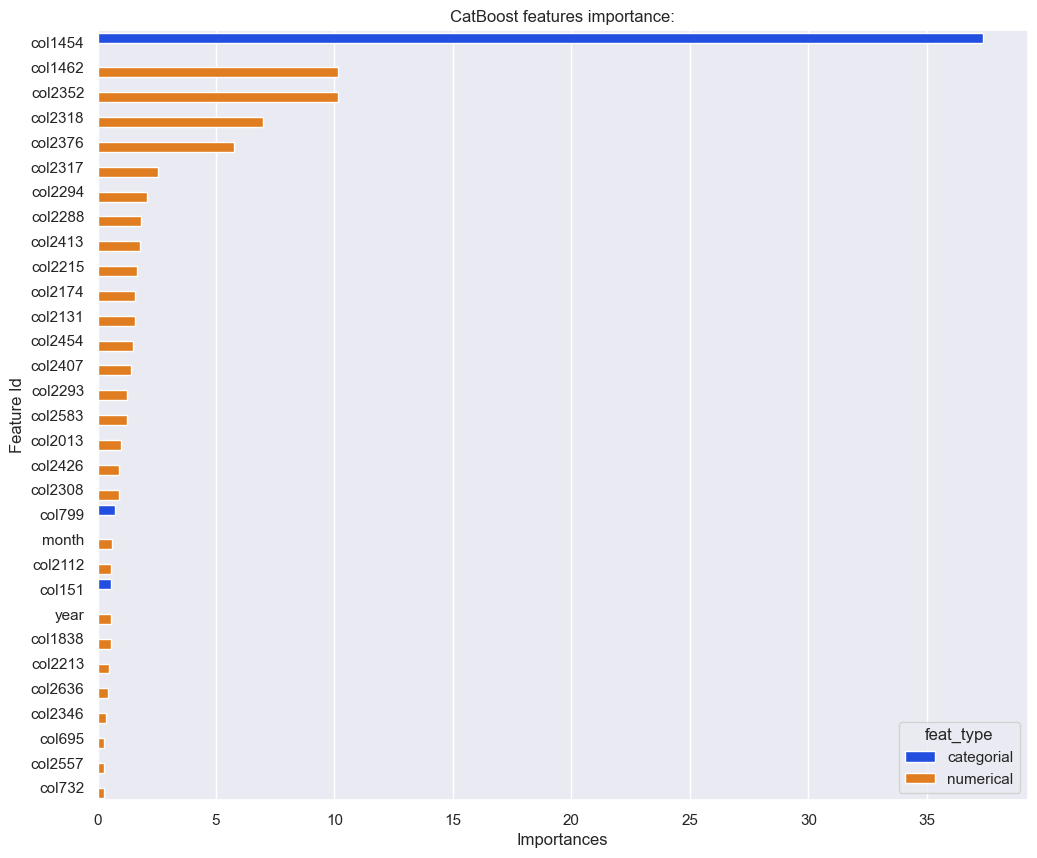

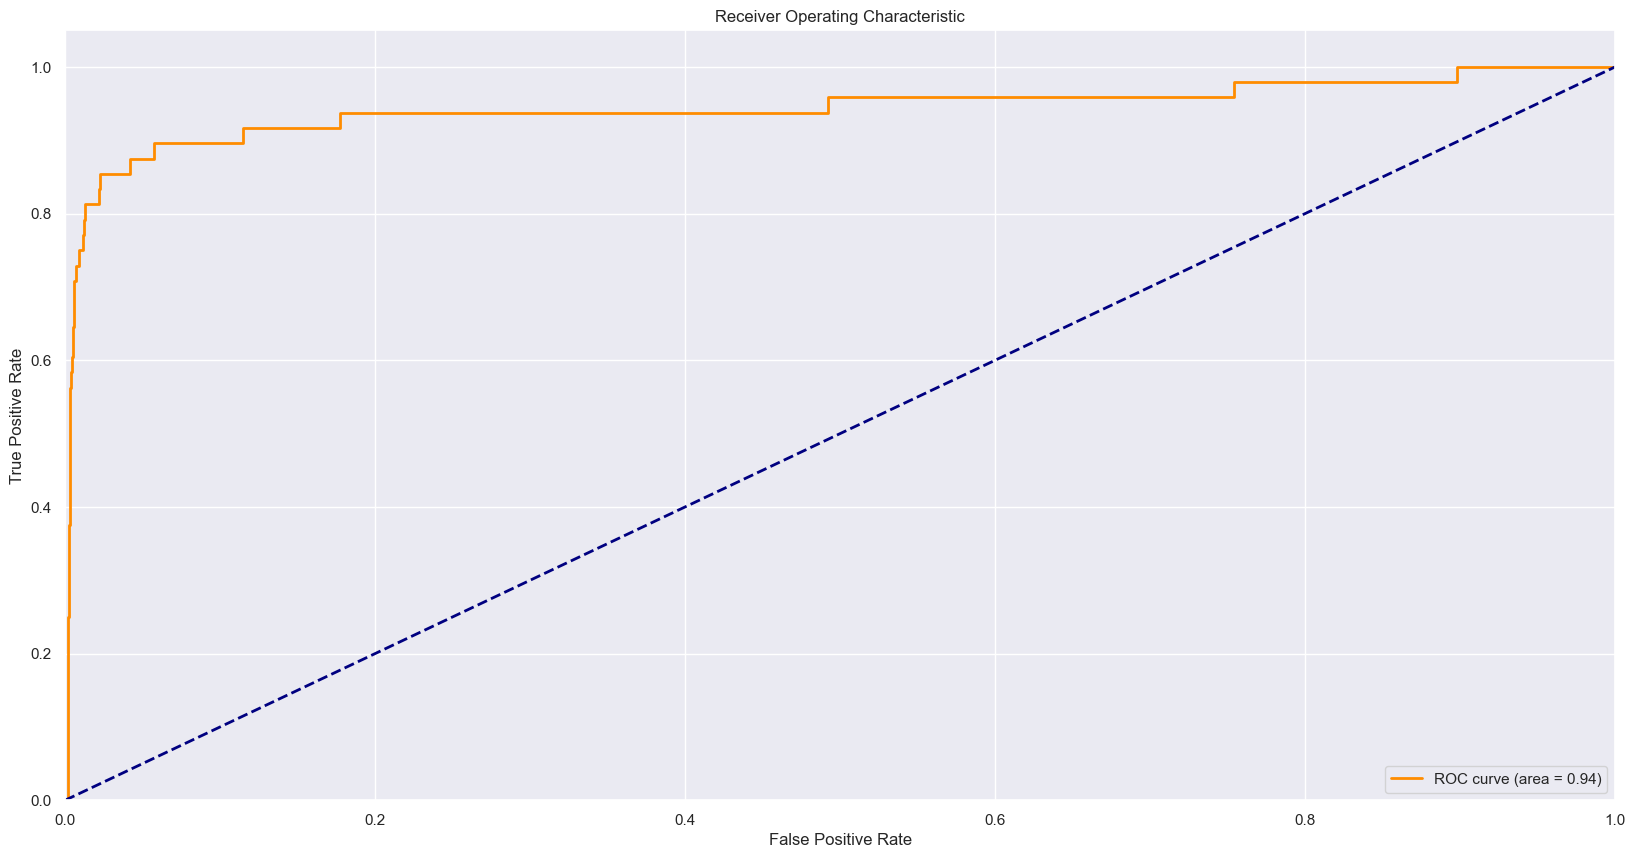

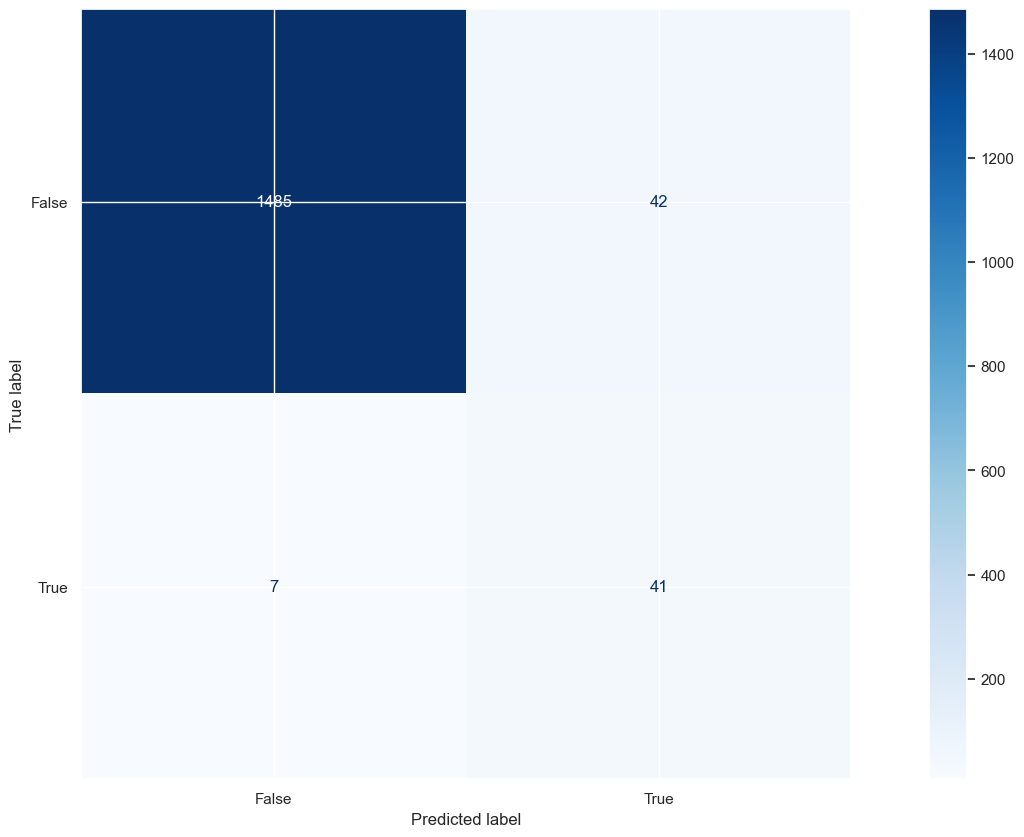

In [34]:
plot_model_info(
    model_best,
    X_test_cleaned,
    y_test,
)

# Step 6. Add Logistic Regression

In [36]:
preprocessor = get_transformer_data_for_regression(X_train_cleaned)

In [37]:
X_train_linear = preprocessor.transform(X_train_cleaned)
X_test_linear = preprocessor.transform(X_test_cleaned)

PCA(n_components=64, svd_solver='full')

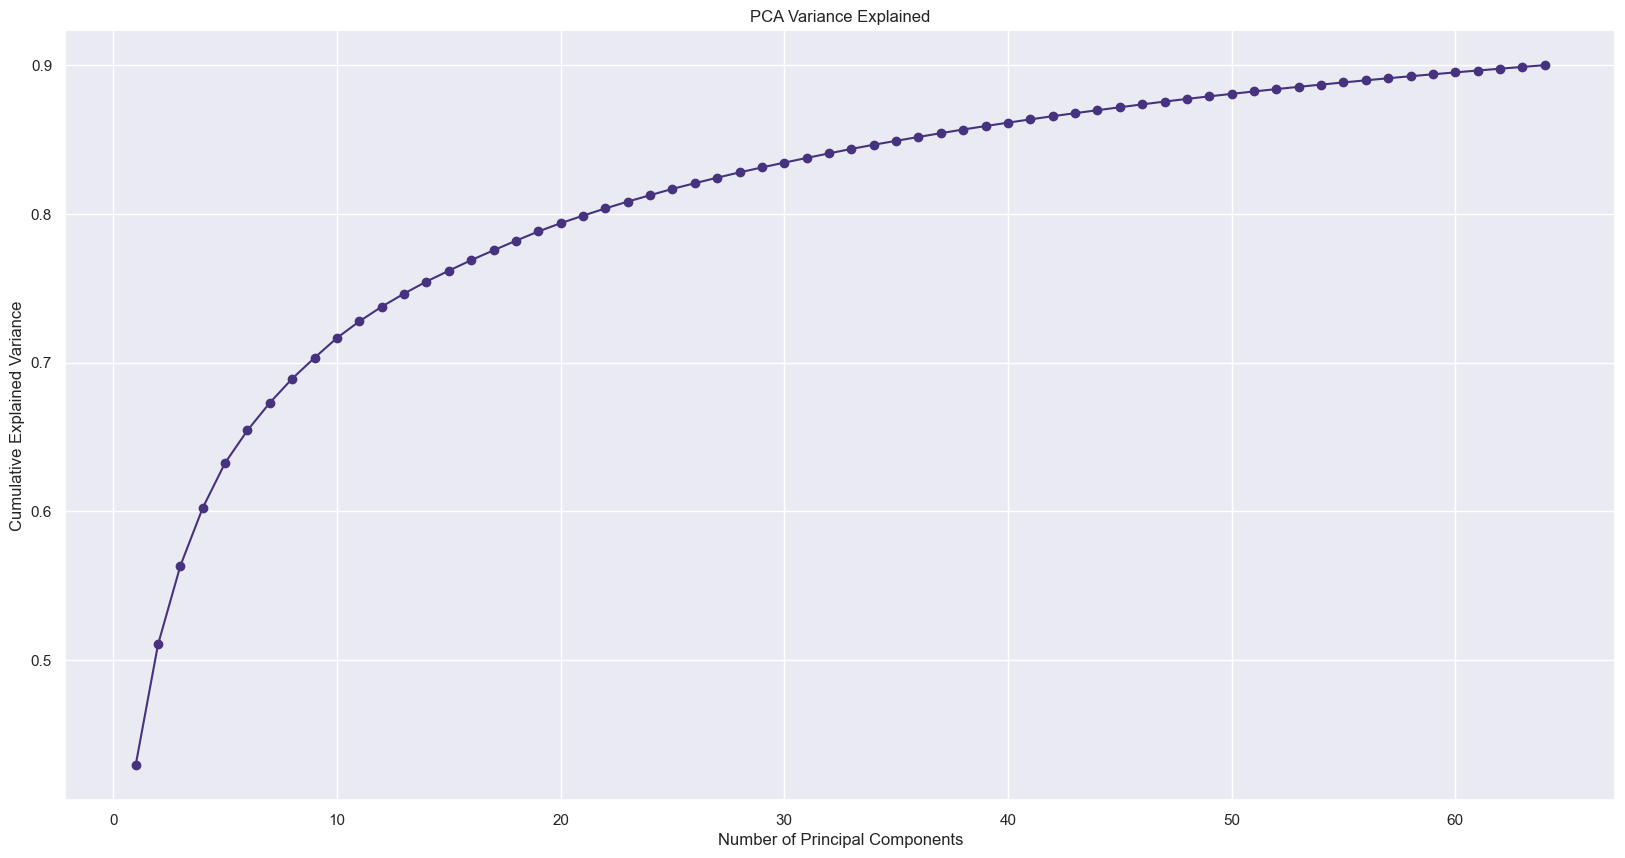

In [38]:
pca = PCA(n_components=min(100, len(X_train_cleaned.columns)), svd_solver='full')
pca.fit(X_train_linear)
plot_pca_variance(pca)

In [39]:
top_n = 60
train_pca = pca.fit_transform(X_train_linear)[:, :top_n]  # we select only top N features
test_pca = pca.transform(X_test_linear)[:, :top_n]

### LogisticRegression

In [40]:
logreg = LogisticRegression(random_state=42, class_weight='balanced', n_jobs=10)
logreg.fit(train_pca, y_train)

/Users/filin_va/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', n_jobs=10, random_state=42)

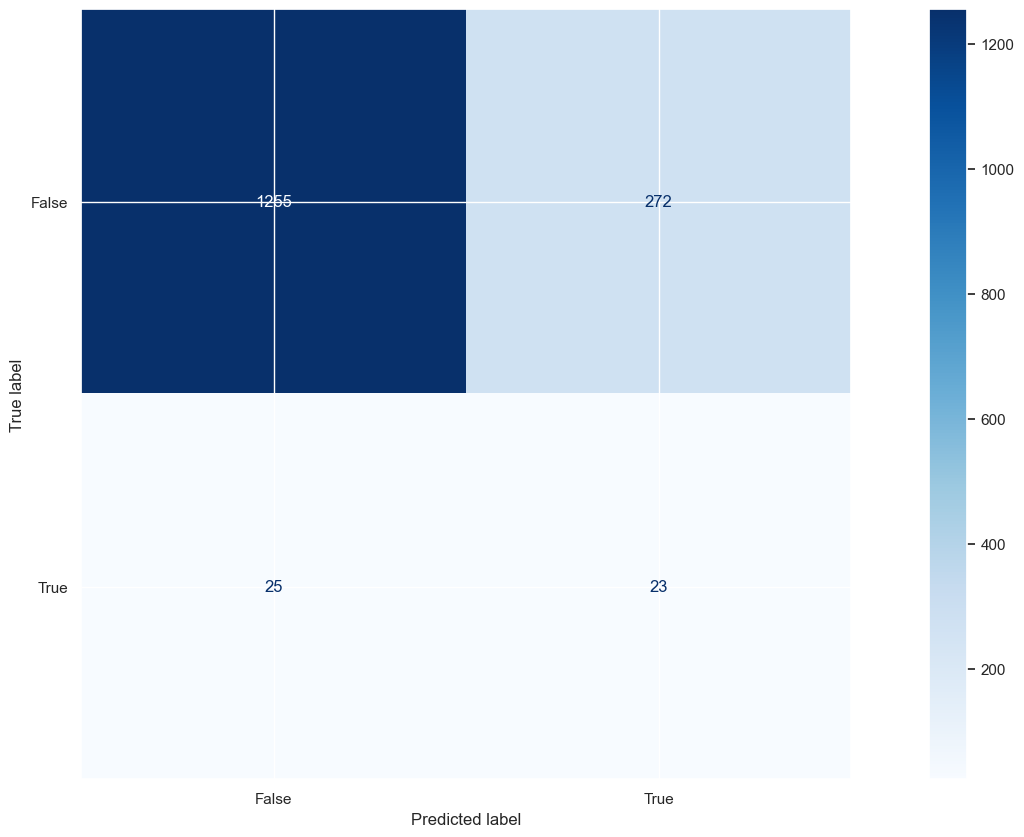

In [41]:
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, logreg.predict(test_pca)), display_labels=[False, True])
cm_display.plot(cmap="Blues")
plt.show()

### LogisticRegressionCV

In [56]:
logreg_cv = LogisticRegressionCV(cv=5, random_state=42, class_weight='balanced', penalty='l2', n_jobs=10)
logreg_cv.fit(train_pca, y_train)

/Users/filin_va/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/filin_va/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

LogisticRegressionCV(class_weight='balanced', cv=5, n_jobs=10, random_state=42)

ROC-AUC score is:  0.6196586444007858


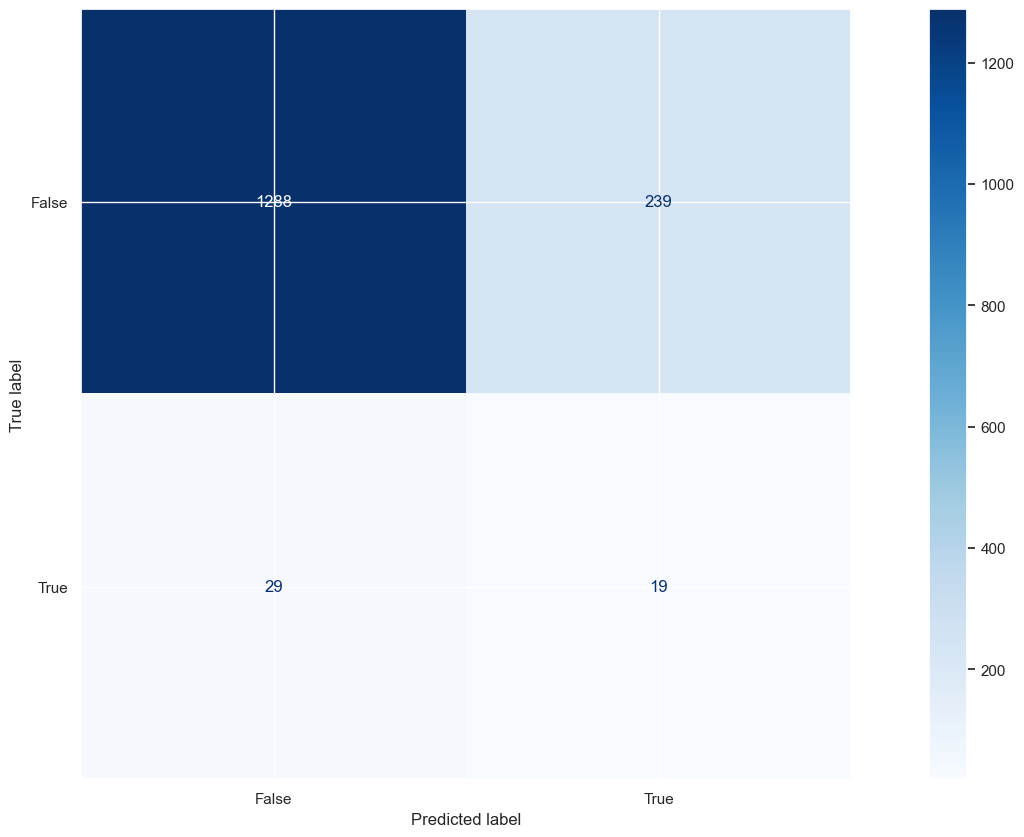

In [57]:
print("ROC-AUC score is: ", roc_auc_score(y_test, logreg_cv.predict(test_pca)))
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, logreg_cv.predict(test_pca)), display_labels=[False, True])
cm_display.plot(cmap="Blues")
plt.show()

# Step 7. CV

# Step 8. Logistic Regression + CatBoost

In [96]:
# Get predictions from both models
cat_boost_preds = model_best.predict_proba(X_test_cleaned)[:, 1]
log_reg_preds = logreg_cv.predict_proba(test_pca)[:, 1]

# Average the predictions
# final_preds = np.mean([log_reg_preds, cat_boost_preds], axis=0)
preds = np.array([cat_boost_preds, log_reg_preds])
final_preds = np.average(preds, weights=[0.6, 0.4], axis=0)

# If you want to convert these to class predictions, you can do so like this:
final_class_preds = [1 if pred > 0.5 else 0 for pred in final_preds]

ROC-AUC score is:  0.912021119842829


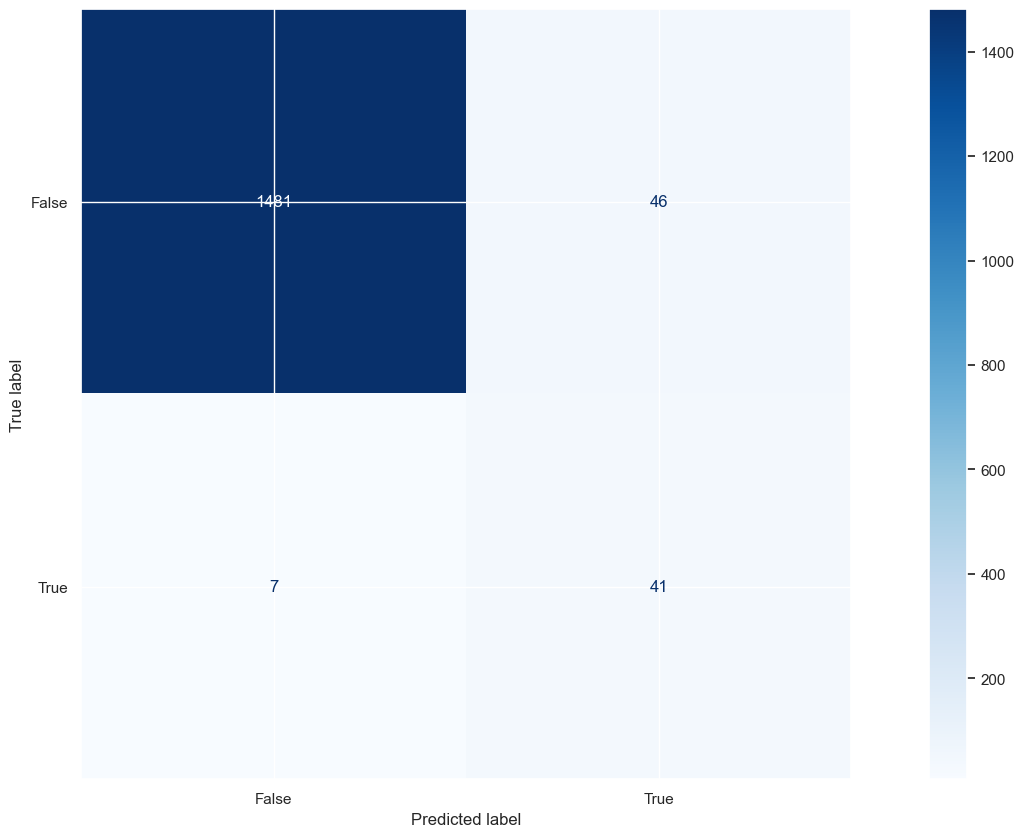

In [97]:
print("ROC-AUC score is: ", roc_auc_score(y_test, final_class_preds))
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, final_class_preds), display_labels=[False, True])
cm_display.plot(cmap="Blues")
plt.show()